In [557]:
import os
import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/halladj/data_set/main/"
#LAPTOPS_PATH = os.path.join("datasets", "labtops")
LAPTOPS_PATH = os.path.join("test_datasets", "labtops")

#LAPTOPS_URL = DOWNLOAD_ROOT + "datasets/laptops/done.csv"
LAPTOPS_URL = DOWNLOAD_ROOT + "test_datasets/laptops/inhanced_test.csv"

def fetch_laptops_data(laptops_url = LAPTOPS_URL, laptops_path = LAPTOPS_PATH):
    os.makedirs(laptops_path, exist_ok= True)
    #file_path = os.path.join(laptops_path, "done.csv")
    file_path = os.path.join(laptops_path, "inhanced_test.csv")
    urllib.request.urlretrieve(laptops_url, file_path)
    
import pandas as pd
import numpy as np

def load_laptops_data(laptops_path = LAPTOPS_PATH):
    #csv_path = os.path.join(laptops_path, "done.csv")
    csv_path = os.path.join(laptops_path, "inhanced_test.csv")
    return pd.read_csv(csv_path, dtype= category_cols)    

In [558]:
category_cols = {item: 'category' for item in ['ram_type', 'cpu_number_identifier', 'brand', 'cpu_family'
                                               , 'cpu_modifier',  'gpu_brand', 'gpu_number_identifier', 'gpu_words_identifier',
                                               'screen_resolution', 'cpu_brand']}

fetch_laptops_data()
laptops= load_laptops_data()

laptops["state"].replace(["new", "used"], [True, False], inplace=True)
laptops["touch_screen"].replace([1, 0], [True, False], inplace=True)
laptops["anti_glare"].replace([1, 0], [True, False], inplace=True)
#####
#laptops["gpu_vram"].replace([0], [None], inplace=True)
#laptops["gpu_brand"].replace([0], [None], inplace=True)
#laptops["gpu_number_identifier"].replace([0], [None], inplace=True)
#laptops["gpu_words_identifier"].replace([0], [None], inplace=True)
#####

laptops["cpu_frequency"].replace([0, np.nan], inplace=True)
laptops["ram_frequency"].replace([0, np.nan], inplace=True)

laptops.dtypes
column_label= laptops["price"]
laptops=laptops.drop(columns=["price"])

In [559]:
laptops_category= laptops[['ram_type', 'brand', 'cpu_family', "cpu_generation",
                           'cpu_modifier', 'gpu_brand', 'gpu_number_identifier', 
                           'gpu_words_identifier','screen_resolution', 'cpu_brand']]
#remove cpu generation
laptops_num= laptops.drop(columns=['ram_type','cpu_number_identifier', 'brand', 'cpu_family',
                                   'cpu_modifier',  'gpu_brand', 'gpu_number_identifier', 
                                   'gpu_words_identifier','screen_resolution', 'cpu_brand'])

#laptops_num= laptops_num.drop(columns=['Back-light', 'gpu_frequency'])
laptops_num= laptops_num.drop(columns=['Back-light'])

In [560]:
print("Shape of the data-set: ", laptops.shape)

Shape of the data-set:  (501, 24)


In [561]:
######
## ONEHOTENCODING
######
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
onehot_encoder= OneHotEncoder()
laptops_category_encoded= onehot_encoder.fit_transform(laptops_category)

In [562]:
######
## NORMALIZATION
######
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler

num_pipeline_full= Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("MinMax_scaler", MinMaxScaler()),
    ("standered_scaler", StandardScaler())
])

num_pipeline_minmax= Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("MinMax_scaler", MinMaxScaler()),
])

num_pipeline_standard= Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("standered_scaler", StandardScaler())
])

num_pipeline_imputer= Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
])


laptops_num_transformed= num_pipeline_imputer.fit_transform(laptops_num)

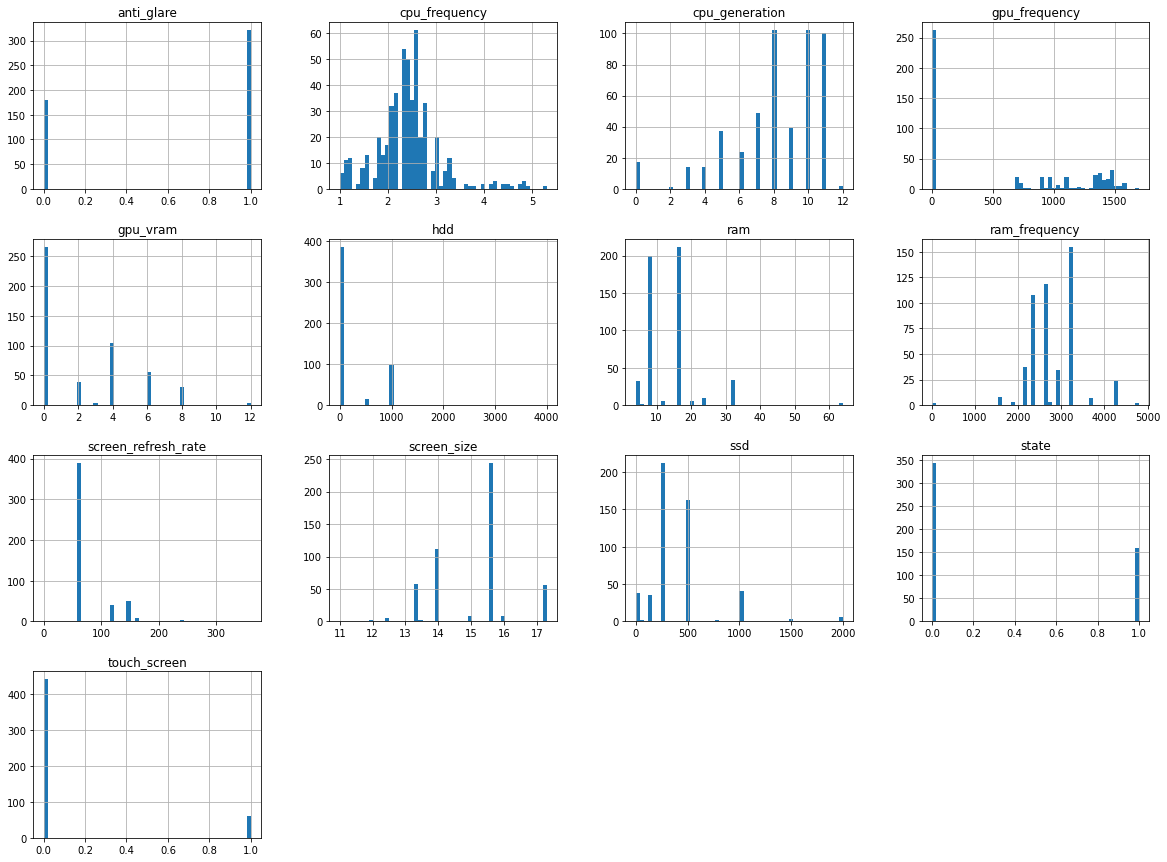

In [563]:
#####
## DATA VISUALIZING
#####
%matplotlib inline
import matplotlib.pyplot as plt


pd.DataFrame(laptops_num_transformed, columns=list(laptops_num.columns)).hist(bins=50, figsize= (20, 15))
plt.show()

In [564]:
category_att= list(category_cols.keys())
num_att= list(laptops_num.columns)


from sklearn.compose import ColumnTransformer

full_pipeline= ColumnTransformer([
    ("num", num_pipeline_full, num_att),
    ("categories", OneHotEncoder(), category_att)
    
])

column_label= column_label.values.reshape(501,1)
laptops_prepared= full_pipeline.fit_transform(laptops)

In [655]:
#####
## DATA SPLIT
#####
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error 
from sklearn.metrics import explained_variance_score, max_error, mean_absolute_percentage_error, median_absolute_error
                                           
from sklearn.model_selection import train_test_split

def print_matrices(y_test, predictions):
    print("Explained Variance Score: %.2f" % explained_variance_score(y_test, predictions))
    print("Max Error: %.2f" % max_error(y_test, predictions))
    print("Mean Absolute Error: %.2f" % mean_absolute_error(y_test, predictions))
    print("Mean Squared Error: %.2f" % mean_squared_error(y_test, predictions))
    print("Mean Absolute Precentage Error: %.2f" % mean_absolute_percentage_error(y_test, predictions))
    print("Median Absolute Error: %.2f" % median_absolute_error(y_test, predictions))
    print("R2 Score : %.2f" % r2_score(y_test, predictions))
   

    
    

x_train, x_test, y_train, y_test= train_test_split(laptops_prepared, column_label, test_size=0.2, random_state=1)

In [656]:
######
## Least Squars
######
from sklearn.linear_model import LinearRegression


full_pipeline= ColumnTransformer([
    ("num", num_pipeline_full, num_att),
    ("categories", OneHotEncoder(), category_att)
    
])
laptops_prepared= full_pipeline.fit_transform(laptops)
x_train, x_test, y_train, y_test= train_test_split(laptops_prepared, column_label, test_size=0.2, random_state=1)
reg = LinearRegression()
reg.fit(x_train, y_train)

prediction= reg.predict(x_test)


print_matrices(y_test, prediction)

Explained Variance Score: 0.77
Max Error: 314238.92
Mean Absolute Error: 26982.25
Mean Squared Error: 2298886754.25
Mean Absolute Precentage Error: 0.23
Median Absolute Error: 14556.12
R2 Score : 0.77


In [567]:
######
## Ridge

######
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV


full_pipeline= ColumnTransformer([
    ("num", num_pipeline_minmax, num_att),
    ("categories", OneHotEncoder(), category_att)
    
])
laptops_prepared= full_pipeline.fit_transform(laptops)
x_train, x_test, y_train, y_test= train_test_split(laptops_prepared, column_label, test_size=0.2, random_state=1)

ridge_params = {'alpha':[1,2,3,4,5]}
reg= Ridge()
grid = GridSearchCV(reg, param_grid=ridge_params, cv=5,scoring='r2')
grid.fit(x_train, y_train)
print(grid.best_params_)
print(grid.best_score_)




prediction= grid.predict(x_test)
print_matrices(y_test, prediction)

{'alpha': 2}
0.7859256497159061
Explained Variance Score: 0.79
Max Error: 320768.12
Mean Absolute Error: 25291.75
Mean Squared Error: 2114436327.55
Mean Absolute Precentage Error: 0.22
Median Absolute Error: 15912.60
R2 Score : 0.79


In [568]:
######
## Ridge

######
from sklearn.linear_model import Ridge


full_pipeline= ColumnTransformer([
    ("num", num_pipeline_minmax, num_att),
    ("categories", OneHotEncoder(), category_att)
    
])
laptops_prepared= full_pipeline.fit_transform(laptops)
x_train, x_test, y_train, y_test= train_test_split(laptops_prepared, column_label, test_size=0.2, random_state=1)


reg= Ridge()
reg.fit(x_train, y_train)


prediction= reg.predict(x_test)
print_matrices(y_test, prediction)

Explained Variance Score: 0.79
Max Error: 322667.62
Mean Absolute Error: 25458.01
Mean Squared Error: 2158955168.35
Mean Absolute Precentage Error: 0.22
Median Absolute Error: 14219.11
R2 Score : 0.78


In [569]:
# from sklearn.linear_model import RidgeCV


# full_pipeline= ColumnTransformer([
#     ("num", num_pipeline_minmax, num_att),
#     ("categories", OneHotEncoder(), category_att)
    
# ])
# laptops_prepared= full_pipeline.fit_transform(laptops)
# x_train, x_test, y_train, y_test= train_test_split(laptops_prepared, column_label, test_size=0.2, random_state=1)

# ridge_cv_params =
# reg= Ridge()
# grid = GridSearchCV(reg, param_grid=ridge_params, cv=5)
# grid.fit(x_train, y_train)
# print(grid.best_params_)
# print(grid.best_score_)



# reg=Ridge(2)
# reg.fit(x_train, y_train)

# prediction= reg.predict(x_test)
# print_matrices(y_test, prediction)

In [570]:
######
## RidgeCV

######
from sklearn.linear_model import RidgeCV


full_pipeline= ColumnTransformer([
    ("num", num_pipeline_minmax, num_att),
    ("categories", OneHotEncoder(), category_att)
    
])
laptops_prepared= full_pipeline.fit_transform(laptops)
x_train, x_test, y_train, y_test= train_test_split(laptops_prepared, column_label, test_size=0.2, random_state=1)


reg= RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1])
reg.fit(x_train, y_train)

prediction= reg.predict(x_test)
print_matrices(y_test, prediction)

Explained Variance Score: 0.79
Max Error: 322567.15
Mean Absolute Error: 25396.40
Mean Squared Error: 2150815835.43
Mean Absolute Precentage Error: 0.22
Median Absolute Error: 14368.30
R2 Score : 0.79


In [571]:
######
## BayesianRidge
######
from sklearn.linear_model import BayesianRidge

full_pipeline= ColumnTransformer([
    ("num", num_pipeline_minmax, num_att),
    ("categories", OneHotEncoder(), category_att)
    
])
laptops_prepared= full_pipeline.fit_transform(laptops)
x_train, x_test, y_train, y_test= train_test_split(laptops_prepared, column_label, test_size=0.2, random_state=1)


reg= BayesianRidge(alpha_1=1e-06, alpha_2=1e-06,lambda_1=1e-06, lambda_2=1e-06)
reg.fit(x_train.todense(), y_train.ravel())

prediction= reg.predict(x_test)
print_matrices(y_test, prediction)

Explained Variance Score: 0.79
Max Error: 323736.06
Mean Absolute Error: 25426.46
Mean Squared Error: 2167608774.86
Mean Absolute Precentage Error: 0.22
Median Absolute Error: 14249.22
R2 Score : 0.78


In [572]:
#ElasticNet
#without built-in cross-validation
from sklearn.linear_model import ElasticNet
full_pipeline= ColumnTransformer([
    ("num", num_pipeline_full, num_att),
    ("categories", OneHotEncoder(), category_att) 
])

laptops_prepared= full_pipeline.fit_transform(laptops)
x_train, x_test, y_train, y_test= train_test_split(laptops_prepared, column_label, test_size=0.2, random_state=1)
    
params = {'alpha':[1.5,1,2,3,4,5],
               'l1_ratio':[0.85,0.9,0.95,0.99]
               }


reg= ElasticNet()
grid = GridSearchCV(reg, param_grid=params, cv=5,scoring='r2')
grid.fit(x_train, y_train)
print(grid.best_params_)
print(grid.best_score_)




prediction= grid.predict(x_test)
print_matrices(y_test, prediction)
    

{'alpha': 1, 'l1_ratio': 0.99}
0.7833759010565957
Explained Variance Score: 0.78
Max Error: 309243.08
Mean Absolute Error: 28439.19
Mean Squared Error: 2244196570.98
Mean Absolute Precentage Error: 0.25
Median Absolute Error: 18625.26
R2 Score : 0.78


In [573]:
######
## ElasticNetCV
######
from sklearn.linear_model import ElasticNetCV

full_pipeline= ColumnTransformer([
    ("num", num_pipeline_imputer, num_att),
    ("categories", OneHotEncoder(), category_att)
    
])
laptops_prepared= full_pipeline.fit_transform(laptops)
x_train, x_test, y_train, y_test= train_test_split(laptops_prepared, column_label, test_size=0.2, random_state=1)


reg= ElasticNetCV(max_iter=6000,l1_ratio=1,cv=5, random_state=0, alphas=[
                       0.0125, 0.025, 0.05, .125, .25, .5, 1., 2., 4.])
reg.fit(x_train, y_train.ravel())

prediction= reg.predict(x_test)
print_matrices(y_test, prediction)

C:\Users\pc\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:513: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 74977151542.26537, tolerance: 296091175.9663987
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\pc\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:513: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 56507158398.44803, tolerance: 296091175.9663987
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\pc\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:513: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 89557007849.2019, tolerance: 296091175.9663987
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\pc\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:513: Convergen

C:\Users\pc\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:513: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 70556794236.50786, tolerance: 285599430.6333988
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\pc\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:513: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 69860007421.18344, tolerance: 285599430.6333988
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\pc\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:513: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 69477288380.71663, tolerance: 285599430.6333988
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\pc\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:513: Converge

Explained Variance Score: 0.79
Max Error: 319140.64
Mean Absolute Error: 25729.34
Mean Squared Error: 2159733914.59
Mean Absolute Precentage Error: 0.23
Median Absolute Error: 14445.63
R2 Score : 0.78


In [574]:
######
## LarsCV
######
from sklearn.linear_model import LarsCV

full_pipeline= ColumnTransformer([
    ("num", num_pipeline_standard, num_att),
    ("categories", OneHotEncoder(), category_att)
    
])
laptops_prepared= full_pipeline.fit_transform(laptops)
x_train, x_test, y_train, y_test= train_test_split(laptops_prepared, column_label, test_size=0.2, random_state=1)



reg= LarsCV(cv=10, normalize=False)
reg.fit(x_train.todense(), y_train.ravel())

prediction= reg.predict(x_test)
print_matrices(y_test, prediction)

C:\Users\pc\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:615: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 68 iterations, i.e. alpha=3.901e+02, with an active set of 60 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
C:\Users\pc\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:615: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 102 iterations, i.e. alpha=3.437e+02, with an active set of 89 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
C:\Users\pc\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:615: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 108 iterations, i.e. alpha=3.196e+02

C:\Users\pc\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:615: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 229 iterations, i.e. alpha=6.534e+06, with an active set of 171 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
C:\Users\pc\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:615: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 230 iterations, i.e. alpha=5.432e+06, with an active set of 172 regressors, and the smallest cholesky pivot element being 7.376e-08. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
C:\Users\pc\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:615: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 230 iterations, i.e. alpha=4.405e

Explained Variance Score: 0.71
Max Error: 339050.89
Mean Absolute Error: 33270.03
Mean Squared Error: 2966171093.42
Mean Absolute Precentage Error: 0.28
Median Absolute Error: 18713.66
R2 Score : 0.70


C:\Users\pc\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:615: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 180 iterations, i.e. alpha=1.200e+04, with an active set of 138 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
C:\Users\pc\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:615: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 213 iterations, i.e. alpha=4.765e+04, with an active set of 158 regressors, and the smallest cholesky pivot element being 1.825e-08. Reduce max_iter or increase eps parameters.
  warnings.warn('Regressors in active set degenerate. '
C:\Users\pc\anaconda3\lib\site-packages\sklearn\linear_model\_least_angle.py:615: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 227 iterations, i.e. alpha=1.287e

In [575]:
######
## LassoCV
######
from sklearn.linear_model import LassoCV

full_pipeline= ColumnTransformer([
    ("num", num_pipeline_full, num_att),
    ("categories", OneHotEncoder(), category_att)
    
])
laptops_prepared= full_pipeline.fit_transform(laptops)
x_train, x_test, y_train, y_test= train_test_split(laptops_prepared, column_label, test_size=0.2, random_state=1)


reg= LassoCV(cv=4, n_alphas=50,alphas=[
                       0.0125, 0.025, 0.05, .125, .25, .5, 1.])
reg.fit(x_train.todense(), y_train.ravel())

prediction= reg.predict(x_test)
print_matrices(y_test, prediction)

C:\Users\pc\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 48266461295.234474, tolerance: 220431285.7395987
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\pc\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 29439036154.93953, tolerance: 220431285.7395987
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\pc\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17527459834.566025, tolerance: 220431285.7395987
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\pc\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:526: ConvergenceW

Explained Variance Score: 0.79
Max Error: 315496.76
Mean Absolute Error: 25581.74
Mean Squared Error: 2142877790.29
Mean Absolute Precentage Error: 0.23
Median Absolute Error: 14113.34
R2 Score : 0.79


C:\Users\pc\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 81264455010.8639, tolerance: 347320007.98479897
  model = cd_fast.enet_coordinate_descent(


In [576]:
######
## OrthogonalMatchingPursuitCV
######
from sklearn.linear_model import OrthogonalMatchingPursuitCV

full_pipeline= ColumnTransformer([
    ("num", num_pipeline_full, num_att),
    ("categories", OneHotEncoder(), category_att)
    
])
laptops_prepared= full_pipeline.fit_transform(laptops)
x_train, x_test, y_train, y_test= train_test_split(laptops_prepared, column_label, test_size=0.2, random_state=1)


reg= OrthogonalMatchingPursuitCV(cv=4, normalize=False)
reg.fit(x_train.todense(), y_train.ravel())

prediction= reg.predict(x_test)
print_matrices(y_test, prediction)

Explained Variance Score: 0.68
Max Error: 330043.28
Mean Absolute Error: 36439.50
Mean Squared Error: 3218057230.33
Mean Absolute Precentage Error: 0.31
Median Absolute Error: 24902.69
R2 Score : 0.68


In [577]:
######
## ARDRegression
######
from sklearn.linear_model import ARDRegression

full_pipeline= ColumnTransformer([
    ("num", num_pipeline_imputer, num_att),
    ("categories", OneHotEncoder(), category_att)
    
])
laptops_prepared= full_pipeline.fit_transform(laptops)
x_train, x_test, y_train, y_test= train_test_split(laptops_prepared, column_label, test_size=0.2, random_state=1)


reg= ARDRegression()
reg.fit(x_train.todense(), y_train.ravel())

prediction= reg.predict(x_test)
print_matrices(y_test, prediction)

Explained Variance Score: 0.68
Max Error: 330288.82
Mean Absolute Error: 36662.17
Mean Squared Error: 3194887971.28
Mean Absolute Precentage Error: 0.32
Median Absolute Error: 22365.20
R2 Score : 0.68


In [578]:
######
## KNeighborsRegressor
######
from sklearn.neighbors import KNeighborsRegressor

full_pipeline= ColumnTransformer([
    ("num", num_pipeline_minmax, num_att),
    ("categories", OneHotEncoder(), category_att)
    
])
laptops_prepared= full_pipeline.fit_transform(laptops)
x_train, x_test, y_train, y_test= train_test_split(laptops_prepared, column_label, test_size=0.2, random_state=1)


reg= KNeighborsRegressor(n_neighbors=2)
reg.fit(x_train.todense(), y_train.ravel())

prediction= reg.predict(x_test)
print_matrices(y_test, prediction)

Explained Variance Score: 0.77
Max Error: 339500.00
Mean Absolute Error: 24281.69
Mean Squared Error: 2344253133.67
Mean Absolute Precentage Error: 0.21
Median Absolute Error: 10000.00
R2 Score : 0.77


In [579]:
from sklearn.neighbors import KNeighborsRegressor

full_pipeline= ColumnTransformer([
    ("num", num_pipeline_minmax, num_att),
    ("categories", OneHotEncoder(), category_att)
    
])
laptops_prepared= full_pipeline.fit_transform(laptops)
x_train, x_test, y_train, y_test= train_test_split(laptops_prepared, column_label, test_size=0.2, random_state=1)

params = {'n_neighbors':[1,2,3,4,5,6,7,8,9]}
reg= KNeighborsRegressor()
grid = GridSearchCV(reg, param_grid=params, cv=5,scoring='r2')
grid.fit(x_train, y_train)
print(grid.best_params_)
print(grid.best_score_)




prediction= grid.predict(x_test)
print_matrices(y_test, prediction)


{'n_neighbors': 4}
0.6950459108231439
Explained Variance Score: 0.72
Max Error: 372025.00
Mean Absolute Error: 28354.96
Mean Squared Error: 2885403168.33
Mean Absolute Precentage Error: 0.22
Median Absolute Error: 15250.00
R2 Score : 0.71


In [600]:
#######
## MLPRegressor
######
from sklearn.neural_network import MLPRegressor

full_pipeline= ColumnTransformer([
    ("num", num_pipeline_imputer, num_att),
    ("categories", OneHotEncoder(), category_att)
    
])
laptops_prepared= full_pipeline.fit_transform(laptops)
x_train, x_test, y_train, y_test= train_test_split(laptops_prepared, column_label, test_size=0.2, random_state=1)

    
reg=MLPRegressor(random_state=0, max_iter=100000)
reg.fit(x_train.todense(), y_train.ravel())

prediction= reg.predict(x_test)
print_matrices(y_test, prediction)

Explained Variance Score: 0.78
Max Error: 305106.23
Mean Absolute Error: 29215.30
Mean Squared Error: 2199055878.60
Mean Absolute Precentage Error: 0.26
Median Absolute Error: 20596.42
R2 Score : 0.78


In [581]:
#######
## LinearSVR
#######
from sklearn.svm import LinearSVR

full_pipeline= ColumnTransformer([
    ("num", num_pipeline_imputer, num_att),
    ("categories", OneHotEncoder(), category_att)
    
])
laptops_prepared= full_pipeline.fit_transform(laptops)
x_train, x_test, y_train, y_test= train_test_split(laptops_prepared, column_label, test_size=0.2, random_state=1)


params = {'C': [0.01, 0.1, 1, 10,15, 100 ],
          'epsilon':[0.1,0.125,0.2]
         }
reg= LinearSVR()
grid = GridSearchCV(reg, param_grid=params, cv=5,scoring='r2')
grid.fit(x_train, y_train)
print(grid.best_params_)
print(grid.best_score_)


prediction= grid.predict(x_test)
print_matrices(y_test, prediction)


C:\Users\pc\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\pc\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\pc\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\pc\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  re

C:\Users\pc\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\pc\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\pc\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\pc\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\pc\anaconda3\lib\site-packages\sklearn\utils\validation.py:63

C:\Users\pc\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\pc\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\pc\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\pc\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\pc\anaconda3\lib\site-packages\sklearn\utils\validation.py:63

C:\Users\pc\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\pc\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\pc\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\pc\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\pc\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: Conv

{'C': 1, 'epsilon': 0.125}
0.5908796911007592
Explained Variance Score: 0.53
Max Error: 454819.01
Mean Absolute Error: 39701.40
Mean Squared Error: 4746518620.02
Mean Absolute Precentage Error: 0.31
Median Absolute Error: 20378.59
R2 Score : 0.53


C:\Users\pc\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\pc\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\pc\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\pc\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\pc\anaconda3\lib\site-packages\sklearn\utils\validation.py:63

In [582]:
#######
## SVR
#######
from sklearn.svm import SVR

full_pipeline= ColumnTransformer([
    ("num", num_pipeline_full, num_att),
    ("categories", OneHotEncoder(), category_att) 
])

laptops_prepared= full_pipeline.fit_transform(laptops)
x_train, x_test, y_train, y_test= train_test_split(laptops_prepared, column_label, test_size=0.2, random_state=1)
    
reg= SVR()
reg.fit(x_train, y_train)

prediction= reg.predict(x_test)
print_matrices(y_test, prediction)

Explained Variance Score: 0.00
Max Error: 543472.14
Mean Absolute Error: 66707.62
Mean Squared Error: 10735701089.76
Mean Absolute Precentage Error: 0.46
Median Absolute Error: 46462.81
R2 Score : -0.07


C:\Users\pc\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [583]:
#######
## NuSVR
#######
from sklearn.svm import NuSVR

full_pipeline= ColumnTransformer([
    ("num", num_pipeline_full, num_att),
    ("categories", OneHotEncoder(), category_att) 
])

laptops_prepared= full_pipeline.fit_transform(laptops)
x_train, x_test, y_train, y_test= train_test_split(laptops_prepared, column_label, test_size=0.2, random_state=1)
    
reg= NuSVR(C=1.0, nu=0.1)
reg.fit(x_train, y_train)

prediction= reg.predict(x_test)
print_matrices(y_test, prediction)

Explained Variance Score: 0.00
Max Error: 488496.28
Mean Absolute Error: 82980.32
Mean Squared Error: 10837460630.93
Mean Absolute Precentage Error: 0.73
Median Absolute Error: 73496.00
R2 Score : -0.08


C:\Users\pc\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [625]:
#######
## DecisionTreeRegressor
#######
from sklearn.tree import DecisionTreeRegressor, plot_tree

full_pipeline= ColumnTransformer([
    ("num", num_pipeline_full, num_att),
    ("categories", OneHotEncoder(), category_att) 
])

laptops_prepared= full_pipeline.fit_transform(laptops)
x_train, x_test, y_train, y_test= train_test_split(laptops_prepared, column_label, test_size=0.2, random_state=1)
    
reg= DecisionTreeRegressor(random_state=0, max_depth=15,min_samples_leaf=10)
reg.fit(x_train, y_train)

prediction= reg.predict(x_test)
print_matrices(y_test, prediction)

#plot_tree(reg)
#plt.show()

Explained Variance Score: 0.75
Max Error: 290055.56
Mean Absolute Error: 30223.25
Mean Squared Error: 2494652013.38
Mean Absolute Precentage Error: 0.25
Median Absolute Error: 18250.00
R2 Score : 0.75


In [650]:
from sklearn.tree import ExtraTreeRegressor

full_pipeline= ColumnTransformer([
    ("num", num_pipeline_full, num_att),
    ("categories", OneHotEncoder(), category_att) 
])

laptops_prepared= full_pipeline.fit_transform(laptops)
x_train, x_test, y_train, y_test= train_test_split(laptops_prepared, column_label, test_size=0.2, random_state=1)
    
reg= ExtraTreeRegressor(splitter='random',random_state=0, max_depth=8,min_samples_split=5
                        )
reg.fit(x_train, y_train)

prediction= reg.predict(x_test)
print_matrices(y_test, prediction)

#plot_tree(reg)
#plt.show()

Explained Variance Score: 0.85
Max Error: 264000.00
Mean Absolute Error: 20858.30
Mean Squared Error: 1533758357.63
Mean Absolute Precentage Error: 0.20
Median Absolute Error: 11000.00
R2 Score : 0.85


In [586]:
from sklearn.linear_model import SGDRegressor

full_pipeline= ColumnTransformer([
    ("num", num_pipeline_full, num_att),
    ("categories", OneHotEncoder(), category_att) 
])

laptops_prepared= full_pipeline.fit_transform(laptops)
x_train, x_test, y_train, y_test= train_test_split(laptops_prepared, column_label, test_size=0.2, random_state=1)
    
reg= SGDRegressor(max_iter=1000, tol=1e-3)
reg.fit(x_train, y_train)

prediction= reg.predict(x_test)
print_matrices(y_test, prediction)


Explained Variance Score: 0.79
Max Error: 289616.00
Mean Absolute Error: 28435.58
Mean Squared Error: 2139674719.79
Mean Absolute Precentage Error: 0.25
Median Absolute Error: 18460.77
R2 Score : 0.79


C:\Users\pc\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
